In [18]:
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler, PowerTransformer, RobustScaler
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import talib
import optuna
import pickle
import torch
from pytorch_forecasting import TimeSeriesDataSet, NBeats, Baseline
from pytorch_forecasting.metrics import QuantileLoss, MAE, SMAPE
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.tuner import Tuner
import lightning.pytorch as pl
import torch.nn as nn
from torchmetrics import MeanSquaredError
from pytorch_optimizer import Ranger

In [19]:
def load_yaml(file):
    with open(file, 'r') as f:
        config = yaml.safe_load(f)
    return config

In [20]:
config = load_yaml('../config_Transformer.yaml')

In [21]:
#trading_data = pd.read_excel(config['data_excel_path'], sheet_name='Data_Basic')
#trading_data.count()
all_trading_data_dfs = []
sheet_names = ['5minData12-17-2019']
for sheet in sheet_names:
    temp_df = pd.read_excel(config['all_data_excel_path'], sheet_name=sheet)
    all_trading_data_dfs.append(temp_df)
all_trading_data = pd.concat(all_trading_data_dfs, ignore_index=True)

# Load 5 min data
all_trading_data['Date'] = pd.to_datetime(all_trading_data['Date'])


In [22]:
all_trading_data.head()

,Date,Symbol,Open,High,Low,Close,Volume
0,2019-12-17 09:30:00,SPY,319.92,320.020,319.71,319.810,546833
1,2019-12-17 09:35:00,SPY,319.81,320.250,319.81,320.000,995662
2,2019-12-17 09:40:00,SPY,320.00,320.020,319.72,319.780,641910
3,2019-12-17 09:45:00,SPY,319.78,319.830,319.58,319.630,540248
4,2019-12-17 09:50:00,SPY,319.63,319.755,319.59,319.755,445601


In [23]:
##### Set the Date Start and End for the filtering of trading data

train_start_date = pd.to_datetime(config['train_start_date'])
train_end_date = pd.to_datetime(config['train_end_date'])

trading_data_raw = all_trading_data[(all_trading_data['Date'] >= train_start_date) & (all_trading_data['Date'] <= train_end_date)]
trading_data_raw = trading_data_raw.reset_index(drop=True)
trading_data_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7956 entries, 0 to 7955
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    7956 non-null   datetime64[ns]
 1   Symbol  7956 non-null   object        
 2   Open    7956 non-null   float64       
 3   High    7956 non-null   float64       
 4   Low     7956 non-null   float64       
 5   Close   7956 non-null   float64       
 6   Volume  7956 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 435.2+ KB


In [24]:
trading_data_raw.drop(columns=['Symbol'], inplace=True)

In [25]:
trading_data_diff = trading_data_raw.copy()
if config['do_relative_diff']:
    trading_data_diff.iloc[:, 1:] = trading_data_diff.iloc[:, 1:].diff()
    trading_data_diff.iloc[0, 1:] = 0 
trading_data_diff.head()

,Date,Open,High,Low,Close,Volume
0,2023-01-03 09:30:00,384.37,385.12,383.5900,384.5100,1705209
1,2023-01-03 09:35:00,384.54,385.44,384.3250,385.3900,810209
2,2023-01-03 09:40:00,385.41,386.43,385.1655,385.2800,1413987
3,2023-01-03 09:45:00,385.29,385.40,383.0200,383.5000,1500245
4,2023-01-03 09:50:00,383.49,383.96,382.5000,382.8001,1118161


In [26]:
trading_data_raw.head()

,Date,Open,High,Low,Close,Volume
0,2023-01-03 09:30:00,384.37,385.12,383.5900,384.5100,1705209
1,2023-01-03 09:35:00,384.54,385.44,384.3250,385.3900,810209
2,2023-01-03 09:40:00,385.41,386.43,385.1655,385.2800,1413987
3,2023-01-03 09:45:00,385.29,385.40,383.0200,383.5000,1500245
4,2023-01-03 09:50:00,383.49,383.96,382.5000,382.8001,1118161


In [27]:
n_bars = config['n_past']
m_bars = config['m_future']

In [28]:
#dataset = StockDataset( df=trading_data_raw, n_past=n_bars, m_future=m_bars)
#print("Dataset size : ", len(dataset))

In [29]:
#feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
#feature_columns = config['feature_columns'].split(',')

feature_columns2 = ['Open', 'High', 'Low', 'Volume']
fourier_lookback_window = config['fourier_lookback_window']
fourier_n_components = config['fourier_n_components']

In [30]:
def calculate_bollinger_bands(data, window_size, num_std_dev):
    rolling_mean = data['Close'].rolling(window=window_size).mean()
    rolling_std = data['Close'].rolling(window=window_size).std()
    data['BOLLBU'] = rolling_mean + (rolling_std * num_std_dev)
    data['BOLLBM'] = rolling_mean
    data['BOLLBL'] = rolling_mean - (rolling_std * num_std_dev)
    
    return data

def calculate_donchn_bands(data, window_size):
    data['DONCH_U'] = data['High'].rolling(window=window_size).max()
    data['DONCH_L'] = data['Low'].rolling(window=window_size).min()
    
    return data
    
def calculate_tchr(data):
    period = config['tchr_period']
    retracement = config['tchr_retracement']
    adj = config['tchr_adj']
    range = config['tchr_range']

    if range == 'highlow':
        data['TCHR_U'] = talib.MAX(data['High'], timeperiod=period) + adj
        data['TCHR_L'] = talib.MIN(data['Low'], timeperiod=period) - adj
    elif range == 'close':
        data['TCHR_U'] = talib.MAX(data['Close'], timeperiod=period) + adj
        data['TCHR_L'] = talib.MIN(data['Close'], timeperiod=period) - adj
    
    #calculate retracement
    if retracement == "long":
        data['TCHR'] = (data['Close'] - data['TCHR_L']) / (data['TCHR_U'] - data['TCHR_L'])
    elif retracement == "short":
        data['TCHR'] = (data['TCHR_U'] - data['Close']) / (data['TCHR_U'] - data['TCHR_L'])
    
    return data
    
def calculate_adwm(data):
    period = config['adwm_period']
    data['Previous_Close']= data['Close'].shift(1)
    data['TRH'] = data[['High', 'Previous_Close']].max(axis=1)
    data['TRL'] = data[['Low', 'Previous_Close']].min(axis=1)

    data['ADWM_AD'] = 0.0
    data.loc[data['Close'] > data['Previous_Close'], 'ADWM_AD'] = (data['Close'] - data['TRL'])
    data.loc[data['Close'] < data['Previous_Close'], 'ADWM_AD'] = (data['Close'] - data['TRH'])

    data['ADWM'] = data['ADWM_AD']

    data['ADWMMA'] = data['ADWM'].rolling(window=period).mean()

    return data

def calculate_si(row, prev_row, limit):
    if pd.isna(prev_row['Close']):
        return 0
    c = row['Close']
    c_prev = prev_row['Close']
    o = row['Open']
    o_prev = prev_row['Open']
    return (50 * ((c - c_prev) + (0.5 * (c - o)) + (0.25 * (c_prev - o_prev))) / limit)

def calculate_WASI(data):
    wasi_limit = config['wasi_limit']
    data['SI'] = data.apply(lambda row: calculate_si(row, data.shift(1).loc[row.name], wasi_limit), axis=1)
    data['WASI'] = data['SI']
    return data

def calculate_ATR(data):
    atr_period = config['atr_period']
    atr_ma = config['atr_ma']
    data['ATR'] = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=atr_period)
    data['ADJATR'] = talib.SMA(data['ATR'], timeperiod=atr_ma)
    return data


def compute_fourier_df(value_series, n_components=10):
    fft_result = np.fft.fft(value_series)
    real = fft_result.real[:n_components]
    imag = fft_result.imag[:n_components]
    mag = np.abs(fft_result)[:n_components]

    return real, imag, mag

def get_fourier_columns():
    return [f'fourier_real_{j+2}' for j in range(fourier_n_components-1)] + [f'fourier_imag_{j+2}' for j in range(fourier_n_components-1)] + [f'fourier_mag_{j+2}' for j in range(fourier_n_components-1)]   
    

In [31]:
def add_new_features_df(data):
    fourier_lookback_window = config['fourier_lookback_window']
    fourier_n_components = config['fourier_n_components']

    #data['Date'] = pd.to_datetime(data['Date'])
    #print(f"bolband period : {config['bolband_period']}")
    bolband_period = config['bolband_period']
    bolband_width = config['bolband_width']
    upper, middle, lower = talib.BBANDS(data['Close'], timeperiod=bolband_period, nbdevup=bolband_width, nbdevdn=bolband_width, matype=0)
    data['BOLLBU'] = upper
    data['BOLLBM'] = middle
    data['BOLLBL'] = lower
    #data = calculate_bollinger_bands(data, int(config['bolband_period']), int(config['bolband_width']))

    # Calculate DONCHN Bands
    donchn_period = config['donchn_period']
    data['DONUP'] = talib.MAX(data['High'], timeperiod=donchn_period)

    data['DONLOW'] = talib.MIN(data['Low'], timeperiod=donchn_period)

    data['DONMID'] = (data['DONLOW'] + data['DONUP']) / 2

    data['MA20'] = talib.SMA(data['Close'], timeperiod=20)

    data['MA50'] = talib.SMA(data['Close'], timeperiod=50)

    data['MA100'] = talib.SMA(data['Close'], timeperiod=100)

    data['EMA20'] = talib.EMA(data['Close'], timeperiod=20)

    # Calculate the pivot points
    data['PVPT'] = (data['High'] + data['Low'] + data['Close']) / 3
    data['PVPTR1'] = (2 * data['PVPT']) - data['Low']

    data['PVPTR2'] = data['PVPT'] + data['High'] - data['Low']

    data['PVPTR3'] = data['High'] + 2 * (data['PVPT'] - data['Low'])

    data['PVPTS1'] = (2 * data['PVPT']) - data['High']

    data['PVPTS2'] = data['PVPT'] + data['High'] - data['Low']

    data['PVPTS3'] = data['Low'] - 2 * (data['High'] - data['PVPT'])

    data = calculate_tchr(data)

    data = calculate_adwm(data)

    data = calculate_WASI(data)

    volume_ma_period = config['volume_ma_period']

    data['VOLMA'] = talib.SMA(data['Volume'], timeperiod=volume_ma_period)

    data = calculate_ATR(data)

    data['DayofWeek'] = data['Date'].dt.dayofweek

    data['DayofWeek'] = data['DayofWeek'].astype('category')

    # Add fourier columns to the df
    for i in range(fourier_n_components):
        data[f'fourier_real_{i+1}'] = np.nan
        data[f'fourier_imag_{i+1}'] = np.nan
        data[f'fourier_mag_{i+1}'] = np.nan

    features = []
    epsilon = 1e-5
    #print(f"fourier window - 1 : {fourier_lookback_window - 1}")
    for i in range(len(data)):
        if i >= fourier_lookback_window - 1:
            #print("entered point 1")
            close_window = data['Close'].iloc[i - fourier_lookback_window + 1: i + 1].values
            real, imag, mag = compute_fourier_df(close_window, n_components=fourier_n_components)

            for j in range(fourier_n_components):
                data.iloc[i, data.columns.get_loc(f'fourier_real_{j+1}')] = real[j]
                data.iloc[i, data.columns.get_loc(f'fourier_imag_{j+1}')] = imag[j]
                data.iloc[i, data.columns.get_loc(f'fourier_mag_{j+1}')] = mag[j]
                #print(data.loc[i, 'Date'])
    


    # Add the time of day feature to the trading data

    # Define max time of day in minutes
    MAX_TIME_MINUTES = 1440
    data['Minutes_Passed'] = (data['Date'].dt.hour* 60) + data['Date'].dt.minute
    print(f"number of na s : {data['Date'].isna().sum()}")
    data['TimeOfDay_Group'] = (data['Minutes_Passed'] // 5).astype('int')
    data['Sine_TimeOfDay'] = np.sin(2 * np.pi * data['TimeOfDay_Group'] / MAX_TIME_MINUTES)
    data['Cosine_TimeOfDay'] = np.cos(2 * np.pi * data['TimeOfDay_Group'] / MAX_TIME_MINUTES)
    data['Take_Profit_Level'] = (data['Close'] * config['atr_multiplier'] * data['ADJATR'])
    #print(f"Last row after adding features : ")
    #print(data.tail())
    return data


In [32]:
def get_all_feature_columns():
    fourier_features = get_fourier_columns()
    robust_features = config['robust_scale_features'].split(',')
    return robust_features + fourier_features

In [33]:

def get_features(data, inference=False, scalers={}):
    
    # Define global variables

    stand_features = config['stand_scale_features'].split(',')
    stand_features = [x for x in stand_features if x.strip()]
    robust_features = config['robust_scale_features'].split(',')
    robust_features = [x for x in robust_features if x.strip()]
    minmax_features = config['minmax_scale_features'].split(',')
    minmax_features = [x for x in minmax_features if x.strip()]
    fourier_columns = get_fourier_columns()
    # need to use min max scaler for g1
    stand_features = stand_features + fourier_columns

    real_cols = [f'fourier_real_{j+2}' for j in range(fourier_n_components-1)]
    imag_cols = [f'fourier_imag_{j+2}' for j in range(fourier_n_components-1)]
    mag_cols = [f'fourier_mag_{j+2}' for j in range(fourier_n_components-1)]

    if inference:
        scaler = scalers['fourier_minmax']
        real_min, real_max = scaler['real_min'], scaler['real_max']
        imag_min, imag_max = scaler['imag_min'], scaler['imag_max']
        mag_min, mag_max = scaler['mag_min'], scaler['mag_max']

    else:
        real_min, real_max = data[real_cols].min().min(), data[real_cols].max().max()
        imag_min, imag_max = data[imag_cols].min().min(), data[imag_cols].max().max()
        mag_min, mag_max = data[mag_cols].min().min(), data[mag_cols].max().max()
        fourier_min_max = {
                    'real_min': real_min, 'real_max': real_max,
                    'imag_min': imag_min, 'imag_max': imag_max,
                    'mag_min': mag_min,'mag_max': mag_max,
                    }
        with open(f'../{config['fourier_minmax_path']}', 'wb') as f:
            pickle.dump(fourier_min_max, f)
    
    
    data[real_cols] = (data[real_cols] - real_min) / (real_max - real_min)
    data[imag_cols] = (data[imag_cols] - imag_min) / (imag_max - imag_min)
    data[mag_cols] = (data[mag_cols] - mag_min) / (mag_max - mag_min)

    # Apply standard scaler to g2
    #print("Before standard scaler")
    if inference and 'stand' in scalers.keys():
        scaler = scalers['stand']
        data[stand_features] = scaler.transform(data[stand_features])
    else:
        scaler = StandardScaler()
        data[stand_features] = scaler.fit_transform(data[stand_features])
        #print("After standard scaler")

        with open(f'../{config['stand_scaler_path']}', 'wb') as f:
            pickle.dump(scaler, f)
    

    # Apply minmax scaler
    if inference:
        scaler = scalers['minmax']
        data[minmax_features] = scaler.transform(data[minmax_features])

    else:
        scaler = MinMaxScaler()
        data[minmax_features] = scaler.fit_transform(data[minmax_features])

        with open(f'../{config['minmax_scaler_path']}', 'wb') as f:
            pickle.dump(scaler, f)
  

    return data


#### Add additional features

In [34]:
#trading_data_raw = add_new_features_df(trading_data_raw)

In [35]:
trading_data_cleaned = trading_data_raw.dropna()
trading_data_cleaned = trading_data_cleaned.reset_index(drop=True)
trading_data_cleaned.head()

,Date,Open,High,Low,Close,Volume
0,2023-01-03 09:30:00,384.37,385.12,383.5900,384.5100,1705209
1,2023-01-03 09:35:00,384.54,385.44,384.3250,385.3900,810209
2,2023-01-03 09:40:00,385.41,386.43,385.1655,385.2800,1413987
3,2023-01-03 09:45:00,385.29,385.40,383.0200,383.5000,1500245
4,2023-01-03 09:50:00,383.49,383.96,382.5000,382.8001,1118161


In [80]:
scaler = RobustScaler()
trading_data_scaled = trading_data_cleaned.copy()
trading_data_scaled[['Close']] = scaler.fit_transform(trading_data_cleaned[['Close']])

### Exploratory Data Analysis

In [38]:
'''
plt.figure(figsize=(14,6))
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                    row_heights=[0.7, 0.3],
                    subplot_titles=("Candlestick Chart" , "TCHR"))

# Add candlestick
fig.add_trace(go.Candlestick(x=trading_data_cleaned['Date'],
                open=trading_data_cleaned['Open'],
                high=trading_data_cleaned['High'],
                low=trading_data_cleaned['Low'],
                close=trading_data_cleaned['Close'], name="market data"), row=1, col=1)
# Add moving averages
bolband=False
donband=True
MABand = False

if MABand:
    fig.add_trace(go.Scatter(x=trading_data_cleaned['Date'], y=trading_data_cleaned['MA20'], line=dict(width=1), name="MA20", line_color='blue'), row=1, col=1)
    fig.add_trace(go.Scatter(x=trading_data_cleaned['Date'], y=trading_data_cleaned['MA50'], line=dict(width=1), name="MA50", line_color='red'), row=1, col=1)
    fig.add_trace(go.Scatter(x=trading_data_cleaned['Date'], y=trading_data_cleaned['MA100'], line=dict(width=1), name="MA100", line_color='green'), row=1, col=1)

# Add Bollinger Bands
if bolband:
    fig.add_trace(go.Scatter(x=trading_data_cleaned['Date'], y=trading_data_cleaned['BOLLBU'], mode="lines", line=dict(width=1), name="Bollinger Bands Upper", line_color='red'), row=1, col=1)
    fig.add_trace(go.Scatter(x=trading_data_cleaned['Date'], y=trading_data_cleaned['BOLLBM'], line=dict(width=1), name="Bollinger Bands Middle", line_color='blue'), row=1, col=1)
    fig.add_trace(go.Scatter(x=trading_data_cleaned['Date'], y=trading_data_cleaned['BOLLBL'], line=dict(width=1), name="Bollinger Bands Lower", line_color='green'), row=1, col=1)

# Add Donchian Channels
if donband:
    fig.add_trace(go.Scatter(x=trading_data_cleaned['Date'], y=trading_data_cleaned['DONUP'], line=dict(width=1), name="Donchian Channel Upper", line_color='red'), row=1, col=1)
    fig.add_trace(go.Scatter(x=trading_data_cleaned['Date'], y=trading_data_cleaned['DONLOW'], line=dict(width=1), name="Donchian Channel Lower", line_color='green'), row=1, col=1)
    fig.add_trace(go.Scatter(x=trading_data_cleaned['Date'], y=trading_data_cleaned['DONMID'], line=dict(width=1), name="Donchian Channel Middle", line_color='blue'), row=1, col=1)
# Add TCHR
fig.add_trace(go.Scatter(x=trading_data_cleaned['Date'], y=trading_data_cleaned['TCHR'], line=dict(width=1), name="Trend Channel", line_color='black'), row=2, col=1)

# Layout Settings
fig.update_layout(
    title="Stock Price",
    xaxis_title="Date",
    yaxis_title="Price",
    xaxis_rangeslider_visible=False,
    yaxis=dict(fixedrange=False), 
    xaxis=dict(type='category')
)


fig.show()


plt.plot(trading_data_raw.index, trading_data_raw['Close'], label='Close Price', color='black')
plt.plot(trading_data_raw.index, trading_data_raw['BOLLBU'], label='Bollinger Band Upper', color='red')
plt.plot(trading_data_raw.index, trading_data_raw['BOLLBM'], label='Bollinger Band Middle', color='blue')
plt.plot(trading_data_raw.index, trading_data_raw['BOLLBL'], label='Bollinger Band Lower', color='green')
plt.plot(trading_data_raw.index, trading_data_raw['MA20'], label='MA50', color='blue', linestyle='dashed')
plt.plot(trading_data_raw.index, trading_data_raw['MA50'], label='MA50', color='red', linestyle='dashed')
plt.plot(trading_data_raw.index, trading_data_raw['MA100'], label='MA100', color='green', linestyle='dashed')
plt.plot(trading_data_raw.index, trading_data_raw['DONUP'], label='Donchian Upper', color='red', linestyle='dotted')
plt.plot(trading_data_raw.index, trading_data_raw['DONLOW'], label='Donchian Lower', color='green', linestyle='dotted')
plt.plot(trading_data_raw.index, trading_data_raw['DONMID'], label='Donchian Middle', color='blue', linestyle='dotted')
plt.fill_between(trading_data_raw.index, trading_data_raw['BOLLBL'], trading_data_raw['BOLLBU'], color='gray', alpha=0.5)
plt.legend()
plt.title("Stock price with features")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid()
plt.show()

# 🎨 Volume Analysis
plt.figure(figsize=(14, 4))
plt.bar(trading_data_raw.index, trading_data_raw["Volume"], color="gray", alpha=0.6)
plt.title("Trading Volume")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.grid()
plt.show()
'''

'\nplt.figure(figsize=(14,6))\nfig = make_subplots(rows=2, cols=1, shared_xaxes=True, \n                    row_heights=[0.7, 0.3],\n                    subplot_titles=("Candlestick Chart" , "TCHR"))\n\n# Add candlestick\nfig.add_trace(go.Candlestick(x=trading_data_cleaned[\'Date\'],\n                open=trading_data_cleaned[\'Open\'],\n                high=trading_data_cleaned[\'High\'],\n                low=trading_data_cleaned[\'Low\'],\n                close=trading_data_cleaned[\'Close\'], name="market data"), row=1, col=1)\n# Add moving averages\nbolband=False\ndonband=True\nMABand = False\n\nif MABand:\n    fig.add_trace(go.Scatter(x=trading_data_cleaned[\'Date\'], y=trading_data_cleaned[\'MA20\'], line=dict(width=1), name="MA20", line_color=\'blue\'), row=1, col=1)\n    fig.add_trace(go.Scatter(x=trading_data_cleaned[\'Date\'], y=trading_data_cleaned[\'MA50\'], line=dict(width=1), name="MA50", line_color=\'red\'), row=1, col=1)\n    fig.add_trace(go.Scatter(x=trading_data_clea

#### Scale and Process the features

#### Prepare trading dataset

In [39]:
def prepare_data(df):

    df['time_idx'] = range(len(df))
    df['stock_id'] = 0

    training_cutoff = df['time_idx'].max() - m_bars

    target = 'Close'
    features = get_all_feature_columns()
    print(f"Features : {features}")
    assert df[target].isna().sum() == 0, "Target column contains NaN values"
    print("Min time_idx:", df["time_idx"].min())
    print("Max time_idx:", df["time_idx"].max())

    # create a new dataset using the TimeSeriesDataSet
    training_dataset = TimeSeriesDataSet(
        df[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target=target,
        group_ids=['stock_id'],
        max_encoder_length=n_bars,
        max_prediction_length=m_bars,
        time_varying_unknown_reals=['Close'],
    )

    validation_dataset = TimeSeriesDataSet.from_dataset(training_dataset, df, min_prediction_idx=training_cutoff + 1)
    
    return training_dataset, validation_dataset

In [74]:

from pytorch_forecasting import MASE


def train_model(df, n_epochs=20,batch_size=64):
    train_dataset, val_dataset = prepare_data(df)
    train_dataloader = train_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = val_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")

    # Define Trainer
    trainer = pl.Trainer(
        max_epochs=n_epochs,
        accelerator="auto",
        gradient_clip_val=0.01,
        callbacks=[early_stop_callback],
        enable_model_summary=True,
    )

    #Define model
    net = NBeats.from_dataset(
        train_dataset, 
        learning_rate=0.002, 
        log_interval=2, 
        log_val_interval=1, 
        weight_decay=1e-2,
        backcast_loss_ratio=1.0,
        widths=[512,256,128,64,32,16],
        dropout=0.1,
        loss=MASE()
    )

    #print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

    # Find optimal learning rate 
    '''
    res = Tuner(trainer).lr_find(tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, early_stop_threshold=1000.0, max_lr=0.3)

    print(f" Suggested learning rate : {res.suggestion()}")
    fig = res.plot(show=True, suggest=True)
    fig.show()
    '''

    #Fit the model
    trainer.fit(
        net, 
        train_dataloaders=train_dataloader, 
        val_dataloaders=val_dataloader
    )
    return net, trainer, val_dataloader

#### Train the Model

In [82]:
model, trainer, val_loader = train_model(trading_data_scaled, n_epochs=5, batch_size=64)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Projects\Trading\Uns_SPY_Trading\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Projects\Trading\Uns_SPY_Trading\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 2.5 M  | train
------------------------------------------------------

Features : ['Open', 'High', 'Low', 'Close', 'BOLLBU', 'BOLLBM', 'BOLLBL', 'DONUP', 'DONMID', 'DONLOW', 'MA20', 'MA50', 'MA100', 'EMA20', 'PVPTR1', 'PVPTR2', 'PVPTR3', 'PVPT', 'PVPTS1', 'PVPTS2', 'PVPTS3', 'Sine_TimeOfDay', 'Cosine_TimeOfDay', 'ADWM', 'ADWMMA', 'WASI', 'ADJATR', 'TCHR', 'Volume', 'VOLMA', 'fourier_real_2', 'fourier_real_3', 'fourier_real_4', 'fourier_real_5', 'fourier_real_6', 'fourier_real_7', 'fourier_real_8', 'fourier_real_9', 'fourier_real_10', 'fourier_imag_2', 'fourier_imag_3', 'fourier_imag_4', 'fourier_imag_5', 'fourier_imag_6', 'fourier_imag_7', 'fourier_imag_8', 'fourier_imag_9', 'fourier_imag_10', 'fourier_mag_2', 'fourier_mag_3', 'fourier_mag_4', 'fourier_mag_5', 'fourier_mag_6', 'fourier_mag_7', 'fourier_mag_8', 'fourier_mag_9', 'fourier_mag_10']
Min time_idx: 0
Max time_idx: 7955


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Projects\Trading\Uns_SPY_Trading\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Projects\Trading\Uns_SPY_Trading\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [83]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_nbeats = NBeats.load_from_checkpoint(best_model_path)


In [84]:
actuals = torch.cat([y[0] for x, y in iter(val_loader)]).to("cpu")
predictions = best_nbeats.predict(val_loader, trainer_kwargs=dict(accelerator="cpu"))
(actuals - predictions).abs().mean()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Projects\Trading\Uns_SPY_Trading\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


tensor(0.0915)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


IndexError: index 1 is out of bounds for dimension 0 with size 1

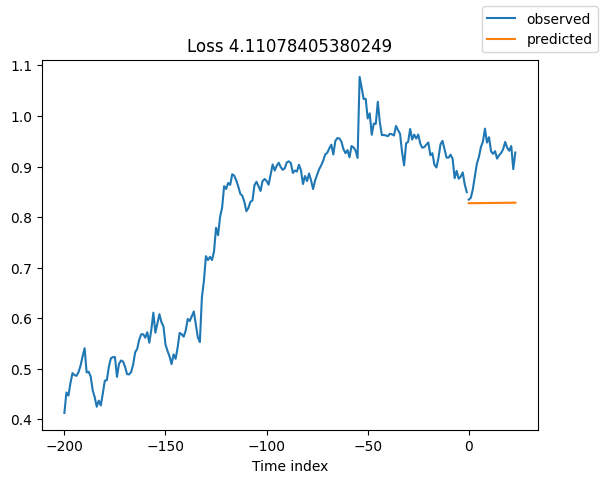

In [86]:
raw_predictions = best_nbeats.predict(val_loader, mode="raw", return_x=True)
for idx in range(5):
    best_nbeats.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


IndexError: index 1 is out of bounds for dimension 0 with size 1

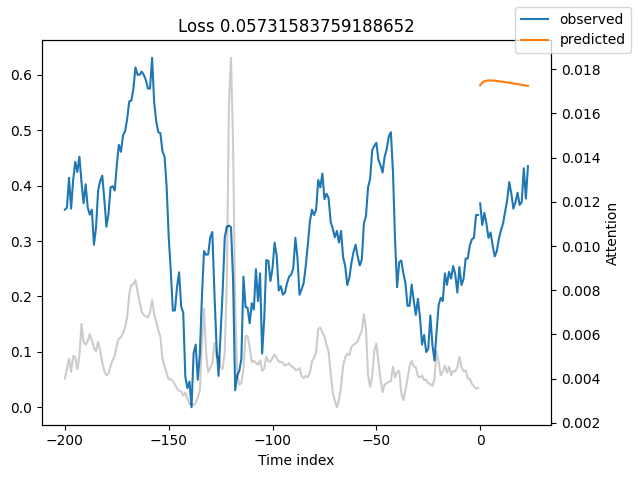

In [ ]:
raw_predictions = best_tft.predict(val_loader, mode="raw", return_x=True)
for idx in range(1):  # plot 10 examples
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)


In [187]:
bolband_period = config['bolband_period']
donchn_period = config['donchn_period']
max_MA_period = 100
max_EMA_period = 20
tchr_period = config['tchr_period']
adwm_period = config['adwm_period']
atr_period = config['atr_period']
volume_ma_period = config['volume_ma_period']
print(f" Fourier window : {fourier_lookback_window}")
max_window = max(bolband_period, 
                 donchn_period, 
                 max_MA_period, 
                 max_EMA_period,
                 tchr_period,
                 adwm_period,
                 atr_period,
                 volume_ma_period, fourier_lookback_window)


 Fourier window : 100


In [188]:


def predict_stock_price(model, t_dataset, df_input, scaler):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    feature_columns = get_all_feature_columns()
    robust_features = config['robust_scale_features'].split(',')
    last_actual_close = df_input.iloc[-1]['Close']
    n_bars = config['n_past']
    m_bars = config['m_future']
    print(f"Last actual close : {last_actual_close}")
    '''
    future_dates = pd.date_range(df_input['Date'].iloc[-1], periods=m_bars+1, freq='5min')[1:]
    df_future = pd.DataFrame({'Date': future_dates})
    df_input = pd.concat([df_input, df_future], ignore_index=True)
    '''
    #Relative scaling
    df_input_diff = df_input.copy()
    if config['do_relative_diff']:
        df_input_diff.iloc[:,1:] = df_input_diff.iloc[:,1:].diff()
        df_input_diff.iloc[0, 1:] = 0
    #Scaling
    df_scaled = df_input_diff.copy()
    if config['use_scaler']:
        df_scaled[feature_columns] = scaler.transform(df_scaled[feature_columns])
    df_scaled['time_idx'] = range(len(df_scaled))
    df_scaled['stock_id'] = 0
    '''
    for col in feature_columns:
        df_scaled.loc[df_scaled.index[-m_bars:], col] = -9999
    df_scaled[feature_columns].iloc[-m_bars:] = -9999
    '''
    #print(df_scaled)
    #print(df_scaled.head())
    '''
    prediction_dataset = TimeSeriesDataSet(
        df_scaled,
        time_idx="time_idx",
        target="Close",
        group_ids=['stock_id'],
        static_categoricals=[],
        max_encoder_length=n_bars,
        min_encoder_length=n_bars,
        max_prediction_length=m_bars,
        min_prediction_length=m_bars,
        time_varying_known_reals=['time_idx'],
        time_varying_unknown_reals=feature_columns,
        target_normalizer=None,
        add_relative_time_idx=True,
        add_target_scales=False,
        add_encoder_length=False
    )

    #Create dataloader for inference
    prediction_dataloader = prediction_dataset.to_dataloader(
        train=False, 
        batch_size=1, 
        num_workers=0,

    )
    '''
    prediction_dataset = TimeSeriesDataSet.from_dataset(t_dataset, df_scaled, predict=True)
    predictions = model.predict(prediction_dataset, mode="prediction")
    '''
    with torch.no_grad():
        for batch in prediction_dataloader:
            x, _ = batch
            x = {key: value.to(device) for key, value in x.items()}
            pred = model.predict(x)
            
            pred = pred[0].cpu().numpy()
            if config['use_mean_or_median'] == 'median':
                val_pred = pred[0][:,2]
            elif config['use_mean_or_median'] == 'mean':
                val_pred = pred[0][:,5]

            #print(f"Prediction initial : {pred}")

            predictions.append(val_pred)

    '''
    pred_np = predictions[0].numpy()
    print("Shape : ", pred_np.shape)
    pred_df = pd.DataFrame(pred_np, columns=['Close'])
    #pred_df = predictions[0].output_predictions.to_dataframe()
    print(f"Predictions shape : {pred_df.shape}")
    print(pred_df.head())
    #print(f"Predictions size : {len(predictions)}")
    #print("Predictions array : ")
    #print(predictions)
    #predictions = np.array(predictions).reshape(-1,1)
    #predictions = predictions[-m_bars:]
    close_idx = robust_features.index('Close')
    
    #scaled_placeholder = np.zeros((predictions.shape[0], len(robust_features)))
    #scaled_placeholder[:, close_idx] = predictions[:, 0]
    placeholder_df = pd.DataFrame(np.zeros((pred_df.shape[0], len(robust_features))), columns=robust_features)
    #if config['use_scaler']:
    #    inverse_transformed = scaler.inverse_transform(scaled_placeholder)
    #else:
    #    inverse_transformed = scaler.inverse_transform(scaled_placeholder)
    
    placeholder_df['Close'] = pred_df['Close']
    print(f"Placeholder shape : {placeholder_df.shape}")
    df_output = placeholder_df.copy()
    df_output[robust_features] = scaler.inverse_transform(placeholder_df[robust_features])    
    #df_output = pd.DataFrame(inverse_transformed, columns=robust_features)
    print(df_output['Close'])
    print(f"Output shape : {df_output.shape}")
    if config['do_relative_diff']:
        df_output['Close'] = df_output['Close'] + last_actual_close
    else:
        pred_close_first = df_output.iloc[0]['Close']
        df_output['Close'] = df_output['Close'] - pred_close_first
    #df_output = df_output.cumsum()


    return df_output

In [ ]:
def load_scalers():
    with open(f'../{config['minmax_scaler_path']}', 'rb') as f:
        minmax_scaler = pickle.load(f)

    with open(f'../{config['fourier_minmax_path']}', 'rb') as f:
        fourier_minmax = pickle.load(f)
    scalers = {
        'fourier_minmax': fourier_minmax, 
        'minmax': minmax_scaler
    }
    return scalers

In [190]:
def predict_data_from_point(model, start_predict_date_str, plot_graph=True):
    pred_start_time = pd.to_datetime(start_predict_date_str)
    pred_start_idx = all_trading_data.index[all_trading_data['Date'] >= pred_start_time][0]
    pred_before_extend = config['pred_before_extend']
    pred_after_extend = config['pred_after_extend']
    start_idx = max(0, pred_start_idx - n_bars - max_window - pred_before_extend)
    end_idx= min(len(all_trading_data), pred_start_idx + m_bars + pred_after_extend)
    trading_data_inference = all_trading_data.loc[start_idx:end_idx].copy()
    trading_data_inference.drop(columns=['Symbol'], inplace=True)
    # Take the first m_bars rows of trading_data_inference
    print(f"Clipping : {pred_start_idx} - {n_bars} - {max_window} = {pred_start_idx - n_bars - max_window}")
    inference_data = all_trading_data.loc[pred_start_idx - n_bars - m_bars - max_window: pred_start_idx].copy()
    #print(inference_data.head())
    inference_data = add_new_features_df(inference_data)
    scalers = load_scalers()
    inference_data = get_features(inference_data, inference=True, scalers=scalers)
    inference_data.dropna(inplace=True)
    predicted_stock_price = predict_stock_price(model, tft_dataset, inference_data, scalers['robust'])
    last_index = inference_data.index[-1]
    last_close = trading_data_inference['Close'].loc[last_index]

    print(f"Last index : {last_index} , last close : {last_close}")
    actual_data = trading_data_inference
    print('actual data shape : ', actual_data.shape)
    predicted_stock_price['Close'] = predicted_stock_price['Close'] + last_close
    #actual_next_predicted = trading_data_inference.iloc[last_index + 1: last_index + 1 + predicted_stock_price.shape[0]]
    actual_next_predicted = trading_data_inference.loc[(last_index + 1): (last_index + 1 + predicted_stock_price.shape[0])]
    print(f"{last_index + 1} : {last_index + 1 + predicted_stock_price.shape[0]}")
    if plot_graph:
        fig = go.Figure()

        fig.add_trace(go.Candlestick(
            x=actual_data["Date"],
            open=actual_data["Open"],
            high=actual_data["High"],
            low=actual_data["Low"],
            close=actual_data["Close"],
            name="Actual Price"
        ))

        # Overlay the Predicted Close Prices as a Red Line
        fig.add_trace(go.Scatter(
            x=actual_next_predicted["Date"],
            y=predicted_stock_price["Close"],
            mode='lines+markers',
            name="Predicted Close",
            line=dict(color='blue', width=2)  # Red line for predictions
        ))

        # Layout Settings
        fig.update_layout(
            title="Stock Price Prediction vs Actual Data",
            xaxis_title="Date",
            yaxis_title="Price",
            xaxis_rangeslider_visible=False,
            yaxis=dict(fixedrange=False), 
            xaxis=dict(type='category')
        )

        # Show the chart
        fig.show()

    return predicted_stock_price
        

In [191]:
pred_prices = predict_data_from_point(model, '2023-05-04 13:25:00', plot_graph=True)

Clipping : 66167 - 200 - 100 = 65867


c:\Projects\Trading\Uns_SPY_Trading\venv\Lib\site-packages\pytorch_forecasting\data\timeseries.py:1693: UserWarning:

If predicting, no randomization should be possible - setting stop_randomization=True

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


number of na s : 0
Last actual close : -3.3785807338267304


c:\Projects\Trading\Uns_SPY_Trading\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: PossibleUserWarning:

The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



Shape :  (24,)
Predictions shape : (24, 1)
      Close
0 -0.519146
1 -0.517589
2 -0.517315
3 -0.517022
4 -0.516412
Placeholder shape : (24, 30)
0     411.523403
1     411.526122
2     411.526601
3     411.527112
4     411.528177
5     411.529792
6     411.531838
7     411.534193
8     411.536757
9     411.539459
10    411.542251
11    411.545101
12    411.547989
13    411.550904
14    411.553835
15    411.556780
16    411.559735
17    411.562699
18    411.565673
19    411.568655
20    411.571646
21    411.574648
22    411.577660
23    411.580685
Name: Close, dtype: float64
Output shape : (24, 30)
Last index : 66167 , last close : 406.5299
actual data shape :  (525, 6)
66168 : 66192
